# CS498PS - Lab 1

The purpose of this lab is to familiarize you with taking a sound to the time/frequency domain and back. You will code a spectrogram routine, its inverse, and then run some examples to see the effects of various parameters when performing such analyses. Although you can find existing functions to perform some of these calculations, you will have to develop your own version from scratch. This will allow you to perform some more complex processing later in the semester, and of course it will also give you a deeper understanding of how things work.

## Part 1. The Forward Transform

You need to design a function that uses five different arguments as follows:
```
	stft_output = stft( input_sound, dft_size, hop_size, zero_pad, window)
		input_sound is a 1d array that contains an input sound.
		dft_size is the DFT point size that you will use for this analysis.
		hop_size is the number of samples that your analysis frame will advance.
		zero_pad is the amount of zero-padding that you will use.
		window is a vector containing the analysis window that you will be using.
```

To complete this you need to perform the following steps:

- You need to segment the input array as shorter frames which are ```dft_size``` samples long. Each frame will start ```hop_size``` samples after the beginning of the previous one. In practice, ```hop_size``` will be smaller than ```dft_size```, usually by a factor of 2 or 4. Feel free to add some zeros at the beginning and/or end of the input so that you have enough samples to compose the last frame at the desired length.

- You will then need to compute the Discrete Fourier Transform (DFT) of each frame. For each input frame you will get a complex-valued vector containing its spectrum. Take all of these vectors and concatenate them as columns of a matrix. The ```{i,j}``` element of this matrix will contain the coefficient for frequency ```i``` at input frame ```j```. Note that there is a variety of Fourier options in numpy. Since we will be using real-valued signals you should use the ```fft.rfft``` routine.

- You might notice that by doing only the above the output is a little noisy-looking. This is because we are not using an analysis window. In order to apply a window you need to multiply each analysis frame with a function that smoothly tapers down to zero. This function will be provided as the input vector window, which will have to have the same length as the analysis frames (i.e. ```dft_size``` samples). Typical window shapes are the triangle window (goes from 0 to 1 to 0), the Hann window (see the incorrectly-named function ```hanning```), the Hamming window (```hamming```), and the Kaiser window (```kaiser```).

- Finally, we will add the option to zero pad the input. Doing so will allow us to obtain smoother looking outputs when ```dft_size``` is small (remember that zero padding in the time domain results in interpolation in the frequency domain). To do so you can append ```zero_pad``` zeros at the end of each analysis frame. Alternatively you can use the ```fft.rfft``` function’s ```size``` variable and ask it to perform a DFT of size ```dft_size+zero_pad```, which will implicitly add zeros to its input.

You should now have a complete forward Short-Time Fourier Transform routine.  Try it on the following example sounds:

- Drum clip: [ https://drive.google.com/uc?export=download&id=1e-pLopbM4WyOFadoxu78E77EvXX4OtYb ]
- Speech clip: [ https://drive.google.com/uc?export=download&id=1dlOQHVi5po7S2CwIWvBsZMJpL17mbFgx ]
- Piano clip: [ https://drive.google.com/uc?export=download&id=1eEFfri_af_QXN4k7xQS2bntyS4VzHLsv ]

and plot the magnitude of the result (you should use the ```pcolormesh``` function to plot it as an image). Try to find the best function parameters that allow you to see what’s going on in the input sounds. You want to get a feel of what it means to change the DFT size, the hop size, the window and the amount of zero padding. Plot some results that demonstrate the effect of these parameters.

Often, such plots lack significant contrast to make a good visualization. A good idea is to plot the log value of the magnitudes (beware of zeros), or to raise them to a small power, e.g. 0.4, or to take their log. This will create better looking plots where smaller differences are more visible. A good colormap is also essential, have a look at: [ https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/ ] You want to use something with a linear luminance gradient.

Finally, I want you to make sure that the axes in your spectrogram plot are in terms of Hz on the y-axis and seconds on the x-axis.

In [1]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

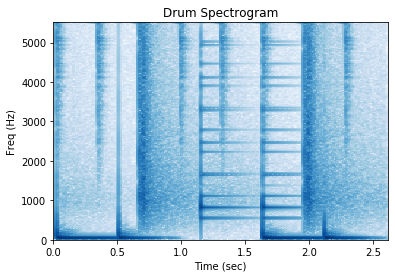

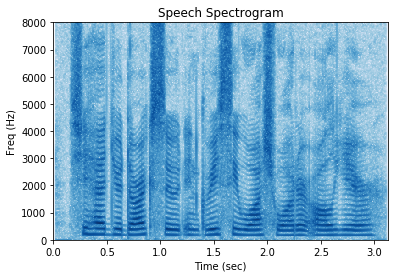

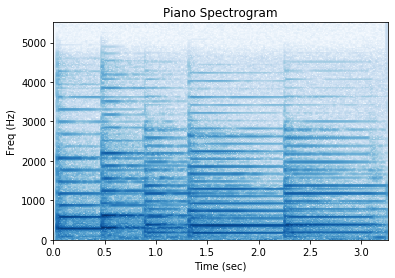

In [2]:
from scipy.io.wavfile import write, read
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

def stft( input_sound, dft_size, hop_size, zero_pad, window):
    # Zero padding to front and end of the input
    zero_padding = np.zeros(dft_size)
    x = np.append(zero_padding, input_sound)
    x = np.append(x, zero_padding)

    # Segment into shorter frames
    frames = []
    for i in range(0, len(x)-dft_size, hop_size):
        # Apply analysis window
        frames.append(x[i:i+dft_size] * window)

    f = []
    for frame in frames:
        freq_vec = np.reshape(np.fft.rfft(frame, dft_size+zero_pad), (-1, 1))
        f.append(freq_vec)

    # Return a complex-valued spectrogram (frequencies x time)
    return np.hstack(f)

# Load each sound
sr_drum, t_drum = read('data/80s.wav')
sr_speech, t_speech = read('data/speech.wav')
sr_piano, t_piano = read('data/piano.wav')

# STFT them
dft_size = 512
hop_size = 128
zero_pad = 32
analysis_window = np.hanning(dft_size)
analysis_window = signal.windows.hann(dft_size, sym=False)

f_drum = stft(t_drum, dft_size, hop_size, zero_pad, analysis_window)
f_speech = stft(t_speech, dft_size, hop_size, zero_pad, analysis_window)
f_piano = stft(t_piano, dft_size, hop_size, zero_pad, analysis_window)

# Plot all the spectrograms
def plot_spectrogram(time, freq, sample_rate, title):
    time_axis = np.linspace(0, len(time)/sample_rate, freq.shape[1])
    freq_axis = np.linspace(0, sample_rate/2, freq.shape[0])
    freq_abs = np.absolute(freq)
    plt.pcolormesh(time_axis, freq_axis, np.log(freq_abs + np.e), cmap='Blues')
    plt.title(title)
    plt.xlabel('Time (sec)')
    plt.ylabel('Freq (Hz)')
    plt.show()
    
plt.figure(1)
plot_spectrogram(t_drum, f_drum, sr_drum, 'Drum Spectrogram')

plt.figure(2)
plot_spectrogram(t_speech, f_speech, sr_speech, 'Speech Spectrogram')

plt.figure(3)
plot_spectrogram(t_piano, f_piano, sr_piano, 'Piano Spectrogram')

## Part 2. The Inverse Transform

We will now implement a function that accepts the output of the function above, and returns the time-domain waveform that produces it. This is known as an inverse Short-Time Fourier Transform. This function will look as follows:

```
    waveform = istft( stft_output, dft_size, hop_size, zero_pad, window)
		stft_output is the 2d array produced by the function you just did in part 1.
		dft_size is the DFT point size that you will use for the resynthesis.
		hop_size is the number of samples that your synthesis frames will advance.
		zero_pad is the amount of zero-padding that you have used originally.
		window is a vector containing the synthesis window that you will be using.
```

Note how this function has the same name as the one above. Use the code you already have, and add a test on whether the input is a 1d array or 2d array (or real-valued or complex-valued). If the input is a real 1d array then you can perform the forward transform from above, otherwise you can perform the inverse transform. To perform the inverse transform you need to complete the following steps.

- Take each spectrum produced by the analysis and perform an inverse DFT on it. For each spectrum you should get back a small snippet of sound that was part of the original input.

- If the hop size you used is the same as the DFT size, you can simply concatenate the waveforms from above and that could recreate the original input (if you didn’t use a window). However since the waveforms in the analysis frames are likely to overlap (which happens when the hop size is smaller than the DFT size), you will need to use an overlap-add procedure. Generate an output array which is as long as the desired output sound and set all its elements to zero. Each time you obtain a waveform frame by applying the inverse DFT on a spectrum from step 1, you will need to add the result at the indices from which the original frame input came. This will effectively superimpose parts of frames that overlap and thus not throw away any information.

- Finally you will need to add the option of a synthesis window. Some of the operations that we will be performing will result in significant changes in the time domain and might create some discontinuities at the ends of the outputs which will result in audible clicks. A good way to ensure that these artifacts go away is to use a synthesis window. This will be a function defined as before, but we will be applying it on the time-domain output of the inverse DFT.

Using the same sounds as above, verify that when you perform a forward transform and then take its inverse, that you get output that sounds like the original (there might be minor numerical differences, you can ignore these). Try to get the resynthesized output to be as close to the input as possible, when using various settings.

Note that you can’t always get perfect reconstruction depending on the parameters you choose. The hop size needs to be equal or smaller than the DFT size otherwise you will lose information (some samples won’t be transformed). When you use a window, you also cause some information to be lost. In the case of the Hann window you should have an overlap of 1/2, 1/4, 1/8, etc. of the DFT size. If not you will get an unintended amplitude modulation. Likewise, if you use a Hann synthesis window, the hop size needs to be at most as large as 1/4 of the DFT size (try this with 1/2 the size and attempt to explain why this is a bad idea).

I suggest you start with no windowing, then use a Hand window for both synthesis and analysis. Make sure that the hop size and windows are such that the COLA principle holds (otherwise you won’t get perfect reconstruction). To ensure that the COLA principle holds you need to make sure that when you add windows which are offset by the hop size they sum to a contant value. If you also use a synthesis window in addition to an analysis window, then you need to make sure that the square of these windows sums to one (because you effectively apply them twice, once for the forward transform, and once for the resynthesis).

In [3]:
def istft( stft_output, dft_size, hop_size, zero_pad, window):
    t = []
    for f in stft_output.T:
        t.append(np.fft.irfft(f, dft_size+zero_pad))
    t = np.array(t)

    x = np.zeros(dft_size+hop_size*(len(t)-1))
    for i in range(len(t)):
        x[i*hop_size:i*hop_size+dft_size] += t[i][:dft_size] * window
    
    # Return reconstructed waveform
    return x[dft_size:]

# Invert all of the spectrograms from the previous assignment
sythesis_window = 1/2
inv_t_drum = istft(f_drum, dft_size, hop_size, zero_pad, window=sythesis_window)
inv_t_speech = istft(f_speech, dft_size, hop_size, zero_pad, window=sythesis_window)
inv_t_piano = istft(f_piano, dft_size, hop_size, zero_pad, window=sythesis_window)

# Play the sounds to make sure they are correct (look out for unwanted clicks, wobbles, etc.)
sound(t_drum, sr_drum, 'Original Drum')
sound(inv_t_drum, sr_drum, 'Resynthesized Drum')
sound(t_speech, sr_speech, 'Original Speech')
sound(inv_t_speech, sr_speech, 'Resynthesized Speech')
sound(t_piano, sr_piano, 'Original Piano')
sound(inv_t_piano, sr_piano, 'Resynthesized Piano')

# Measure your reconstruction error using the original inputs (should be tiny)
def rmse(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

print('RMSE for drum:', rmse(t_drum, inv_t_drum[:len(t_drum)]))
print('RMSE for speech:', rmse(t_speech, inv_t_speech[:len(t_speech)]))
print('RMSE for piano:', rmse(t_piano, inv_t_piano[:len(t_piano)]))

Original Drum


Resynthesized Drum


Original Speech


Resynthesized Speech


Original Piano


Resynthesized Piano


RMSE for drum: 1.1833802476149502e-12
RMSE for speech: 7.01324370282653e-13
RMSE for piano: 8.184450331098718e-13


## Part 3. An Application

Just so you get an idea of how one might use these tools here is a simple example. Take one of the test sounds above and add to it a constant sinusoid with a frequency of 1kHz. When you plot the spectrogram of that sound you should be able to see the sinusoid. Using your code take the spectrogram matrix and set its values that correspond to the sinusoid to zero. Put that back to the inverse stft function and you should get a denoised version of the signal. FYI, this is not a textbook way to solve this problem (it's a little hacky), we'll cover the right way later.

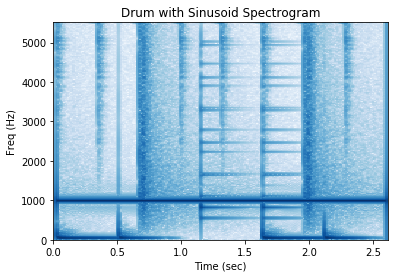

Drum with Sinusoid


Drum Removing Sinusoid


In [4]:
# Load one sound and add to it a 1kHz sinusoid of the same length
def make_sine( frequency, duration, sample_rate):
    t = np.linspace(0, duration, num=int(sample_rate*duration))
    
    return np.sin(2*np.pi*frequency*t)

sample_rate, x = read('data/80s.wav')
freq = 1000
x = x + np.max(x) * make_sine(freq, len(x)/sample_rate, sample_rate)

# Plot the spectrogram of the mix and verify that you can see both sounds
f = stft(x, dft_size, hop_size, zero_pad, analysis_window)
plot_spectrogram(x, f, sample_rate, 'Drum with Sinusoid Spectrogram')
sound(x, sample_rate, 'Drum with Sinusoid')

# Set selected spectrogram values to 0 to "erase" the sinusoid
freq_axis = np.linspace(0, np.max(np.fft.fftfreq(x.size, d=1/sample_rate)), f.shape[0])

erase_index = []
for i, fi in enumerate(freq_axis):
    if abs(freq - fi) < 10:
        erase_index.append(i)

for i in erase_index:
    f[i] = np.zeros(f[i].shape)

# Use your inverse STFT routine to get a playable waveform
inv_x = istft(f, dft_size, hop_size, zero_pad, window=sythesis_window)
sound(inv_x, sample_rate, 'Drum Removing Sinusoid')